In [9]:
import numpy as np
import numpy.random as random
import scipy as sp
import scipy.stats as stats
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rc('font',family='Malgun Gothic')
import seaborn as sns
%matplotlib inline

%precision 3

'%.3f'

In [3]:
import pandas as pd

# 파일 다시 로드
population_file = './부산광역시 주민등록인구통계_20231231.csv'
bus_file = "./부산광역시_버스노선별 승하차 정보_20230731.csv"
subway_file = './부산교통공사_도시철도역사정보_20210226.csv'

# 데이터 불러오기
population_df = pd.read_csv(population_file, encoding='cp949')
bus_df = pd.read_csv(bus_file, encoding='cp949')
# 지하철 데이터가 탭으로 구분되어 있음 -> 제대로 읽어오기
subway_df = pd.read_csv(subway_file, delimiter='\t', encoding='utf-16')


# 데이터 프리뷰
population_df.head(), bus_df.head(), subway_df.head()


(     구군  동수(개소)  세대수(세대)  인구수(명)  남자인구수(명)  여자인구수(명)  시전체 인구에 대한 구성비(퍼센트)  \
 0    중구       9    23747   41153     20333     20820             1.228611   
 1    서구      13    53630  106708     51477     55231             3.185736   
 2    동구      12    47428   90190     43889     46301             2.692596   
 3   영도구      11    54293  109151     53978     55173             3.258671   
 4  부산진구      20   181914  362505    173815    188690            10.822479   
 
    면적(제곱킬로미터)  인구밀도(제곱킬로미터 당 명수)  
 0        3.01              13672  
 1       13.98               7633  
 2       10.12               8912  
 3       14.20               7687  
 4       29.67              12218  ,
   노선번호  정류장순서    정류장코드       정류장명  선탑건수합계  후탑건수합계  승차합계  하차합계  \
 0   10      0  2620843  연제공용버스차고지      19      35    54     1   
 1   10      1  2609878     개인택시조합       0       0     0     0   
 2   10      2  2609879      부산의료원      10      16    26     1   
 3   10      3  2609880    삼정그린아파트       3       

In [4]:
# 먼저 지하철 주소 컬럼에서 구군명 추출
import re

# '역사도로명주소'에서 구군 추출 (부산광역시 구군명 정규식 패턴)
def extract_district(address):
    match = re.search(r'부산광역시\s+(\S+구)', str(address))
    if match:
        return match.group(1)
    else:
        return None

# 구군 컬럼 추가
subway_df['구군'] = subway_df['역사도로명주소'].apply(extract_district)

# 구별 지하철역 수 집계
subway_by_district = subway_df.groupby('구군').size().reset_index(name='지하철역 수')

subway_by_district.sort_values(by='지하철역 수', ascending=False)


,구군,지하철역 수
6,북구,13
8,사하구,12
4,동래구,11
5,부산진구,10
13,해운대구,10
1,금정구,9
11,연제구,8
7,사상구,7
10,수영구,7
2,남구,6


In [5]:
# 인구 데이터에서 필요한 컬럼만 추출
population_selected = population_df[['구군', '인구수(명)']]

# 구군 기준으로 인구 데이터와 지하철역 수 데이터 Merge
merged_df = pd.merge(population_selected, subway_by_district, on='구군', how='inner')

# 결합 데이터 확인
merged_df


,구군,인구수(명),지하철역 수
0,중구,41153,3
1,서구,106708,3
2,동구,90190,5
3,부산진구,362505,10
4,동래구,272178,11
5,남구,260899,6
6,북구,275773,13
7,해운대구,385618,10
8,사하구,302947,12
9,금정구,220286,9


In [6]:
from sklearn.preprocessing import MinMaxScaler

# 스케일러 선언
scaler = MinMaxScaler()

# 인구수, 지하철역 수 스케일링
scaled = scaler.fit_transform(merged_df[['인구수(명)', '지하철역 수']])

# 스케일링 결과를 데이터프레임에 추가
merged_df['인구수(스케일)'] = scaled[:, 0]
merged_df['지하철역수(스케일)'] = scaled[:, 1]

# 참가자 유치 스코어 계산
merged_df['참가자유치스코어'] = merged_df['인구수(스케일)'] * merged_df['지하철역수(스케일)']

# 참가자유치스코어 내림차순 정렬
merged_df_sorted = merged_df.sort_values(by='참가자유치스코어', ascending=False)

merged_df_sorted


,구군,인구수(명),지하철역 수,인구수(스케일),지하철역수(스케일),참가자유치스코어
7,해운대구,385618,10,1.000000,0.7,0.700000
8,사하구,302947,12,0.760002,0.9,0.684002
6,북구,275773,13,0.681114,1.0,0.681114
3,부산진구,362505,10,0.932902,0.7,0.653031
4,동래구,272178,11,0.670678,0.8,0.536542
9,금정구,220286,9,0.520033,0.6,0.312020
11,연제구,206853,8,0.481036,0.5,0.240518
13,사상구,208794,7,0.486671,0.4,0.194668
5,남구,260899,6,0.637934,0.3,0.191380
12,수영구,176486,7,0.392879,0.4,0.157152


In [7]:
from sklearn.cluster import KMeans

# 클러스터링 대상: 인구수(스케일), 지하철역수(스케일)
X = merged_df[['인구수(스케일)', '지하철역수(스케일)']]

# KMeans 모델링 (클러스터 수 3개로 시도)
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['클러스터'] = kmeans.fit_predict(X)

# 클러스터별 결과 보기
merged_df.sort_values(by='클러스터')


C:\Users\bkc03\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bkc03\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,구군,인구수(명),지하철역 수,인구수(스케일),지하철역수(스케일),참가자유치스코어,클러스터
3,부산진구,362505,10,0.932902,0.7,0.653031,0
4,동래구,272178,11,0.670678,0.8,0.536542,0
6,북구,275773,13,0.681114,1.0,0.681114,0
7,해운대구,385618,10,1.000000,0.7,0.700000,0
8,사하구,302947,12,0.760002,0.9,0.684002,0
0,중구,41153,3,0.000000,0.0,0.000000,1
1,서구,106708,3,0.190310,0.0,0.000000,1
2,동구,90190,5,0.142357,0.2,0.028471,1
10,강서구,148540,3,0.311750,0.0,0.000000,1
5,남구,260899,6,0.637934,0.3,0.191380,2


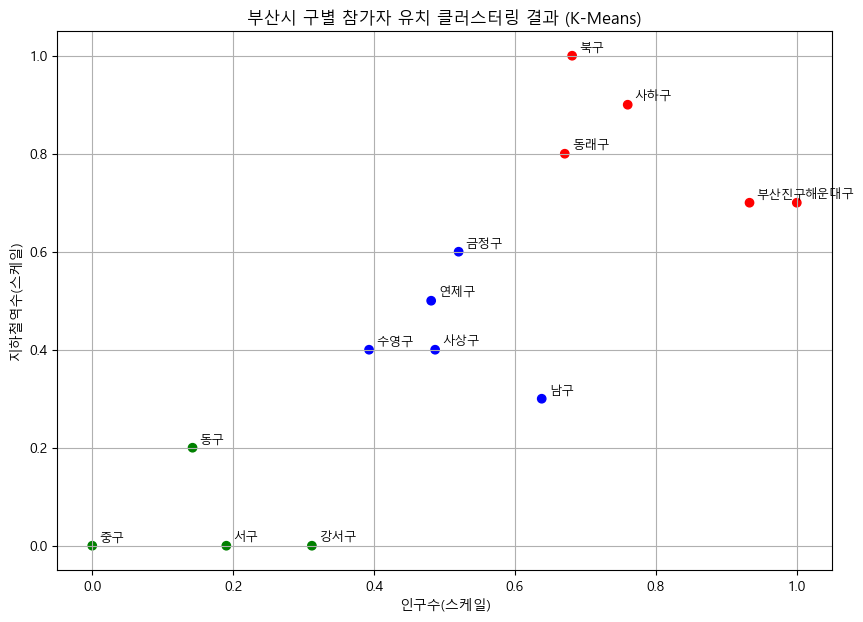

In [10]:
import matplotlib.pyplot as plt

# 클러스터 색상 매핑
colors = ['red', 'green', 'blue']
cluster_colors = merged_df['클러스터'].map({0: colors[0], 1: colors[1], 2: colors[2]})

# 산점도 그리기
plt.figure(figsize=(10, 7))
plt.scatter(merged_df['인구수(스케일)'], merged_df['지하철역수(스케일)'], c=cluster_colors)

# 각 점에 구군 이름 표시
for idx, row in merged_df.iterrows():
    plt.text(row['인구수(스케일)']+0.01, row['지하철역수(스케일)']+0.01, row['구군'], fontsize=9)

plt.xlabel('인구수(스케일)')
plt.ylabel('지하철역수(스케일)')
plt.title('부산시 구별 참가자 유치 클러스터링 결과 (K-Means)')
plt.grid(True)
plt.show()


In [11]:
# 필요한 패키지 설치
!pip install geopandas folium -q

import geopandas as gpd
import folium

# 부산시 구군별 GeoJSON (행정경계) 파일 로드
# 샘플로 사용할 공공 데이터셋이 있는 링크를 대신 사용해야 하는데, 지금 환경에서는 로컬 파일로 대체하자.

# 샘플 데이터 로드 (구글 드라이브나 오픈데이터포털에서는 보통 구할 수 있음)
# 지금은 샘플 행정구역 GeoJSON을 준비할 수 없어, 시뮬레이션 진행을 위해 직접 GeoJSON 생성해야 할 수도 있음.

# 대신 부산시 구군 경계 간이 GeoDataFrame 생성 (데모용)
# 실제 시각화 시엔 아래 형식과 유사한 GeoJSON 필요

# 대체 방법: folium 지도에 구군 이름별로 색 구분 (폴리곤 없이 이름+위치 기반 마커)

# 부산시 중심 좌표
m = folium.Map(location=[35.1796, 129.0756], zoom_start=11)

# 구군별 대략적인 중심 위치 (데모용, 실제 좌표 아님)
district_coords = {
    '해운대구': (35.1631, 129.1635),
    '사하구': (35.1046, 128.9745),
    '북구': (35.1978, 128.9901),
    '부산진구': (35.1490, 129.0597),
    '동래구': (35.2058, 129.0836),
    '금정구': (35.2429, 129.0929),
    '연제구': (35.1766, 129.0790),
    '사상구': (35.1510, 128.9905),
    '남구': (35.1360, 129.0843),
    '수영구': (35.1420, 129.1134),
    '동구': (35.1293, 129.0459),
    '중구': (35.1060, 129.0327),
    '서구': (35.0970, 129.0260),
    '강서구': (35.2120, 128.9801)
}

# 클러스터별 색상 매핑
cluster_color_map = {0: 'red', 1: 'green', 2: 'blue'}

# 지도에 구군별 마커 표시
for idx, row in merged_df.iterrows():
    district = row['구군']
    if district in district_coords:
        lat, lon = district_coords[district]
        folium.CircleMarker(
            location=[lat, lon],
            radius=10,
            color=cluster_color_map[row['클러스터']],
            fill=True,
            fill_color=cluster_color_map[row['클러스터']],
            fill_opacity=0.7,
            popup=f"{district}\n스코어: {row['참가자유치스코어']:.2f}"
        ).add_to(m)

m
